In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from Celldata import Celldata
import time
import multiprocessing as mp
import statistics


from os.path import join
from pathlib import Path
from constants import *
from helper import interpolate_cell_data, interpolate_halfcell, interpolate, normalize
from scipy import optimize
from parser import read_cell_data_csv
from parser import read_halfcell_data_csv
from sklearn.metrics import root_mean_squared_error as rmse
from scipy.interpolate import CubicSpline as CSP
from BatDetector import *


import os
from glob import glob
from matplotlib.lines import Line2D
import matplotlib

In [2]:
# PATH = r'..\iOCVData\Poster'
# EXT = '*.csv'
# for path, subdir, files in os.walk(PATH):
#     for filepath in glob(os.path.join(path, EXT)):
#         print(f'{filepath[0:-3]}txt')
#         file = pd.read_csv(filepath,delimiter=';')
#         txt = file[['C_acc_dis','V_dis']].rename(columns = {'C_acc_dis':"SOC in %", 'V_dis':'U[V]'})
#         txt['SOC in %'] = abs(txt['SOC in %']/max(txt['SOC in %'])-1)
#         txt.to_csv(f'{filepath[0:-3]}txt',sep=' ', index=False)


All Halfcells

In [3]:
path_cathodes = r'../halfcellCathodes'
path_anodes = r'../halfcellAnodes'
EXT = '*.csv'

halfcell_anodes = read_cell_data_csv(path_anodes, True, True)
halfcell_cathodes = read_cell_data_csv(path_cathodes, True, False)

# halfcell_anodes = read_halfcell_data_csv(path_anodes, False, 5)
# halfcell_cathodes = read_halfcell_data_csv(path_cathodes, True, 5)



In [4]:
postive_materials = []
negative_materials = []

for halfcell_anode in halfcell_anodes:
    negative_materials.append(halfcell_anode.get_composition().split(',')[0])

for halfcell_cathode in halfcell_cathodes:
    postive_materials.append(halfcell_cathode.get_composition().split(',')[0])

In [5]:
print(f'Number of Cathode Halfcells {len(halfcell_cathodes)}')
print(f'Number of Anode Halfcells {len(halfcell_anodes)}')

Number of Cathode Halfcells 36
Number of Anode Halfcells 17


In [6]:
print(np.unique(np.array(negative_materials)))
print(np.unique(np.array(postive_materials)))

['Graphite' 'Graphite-Silicon' 'LTO' 'SIB-Hard-Carbon' 'Silicon']
['LCO' 'LFP' 'LMO' 'NCA' 'NCO46' 'NMC' 'NMC111' 'NMC523' 'NMC622' 'NMC811'
 'SIB-NMF']


Text(0.5, 0, 'Lithiation')

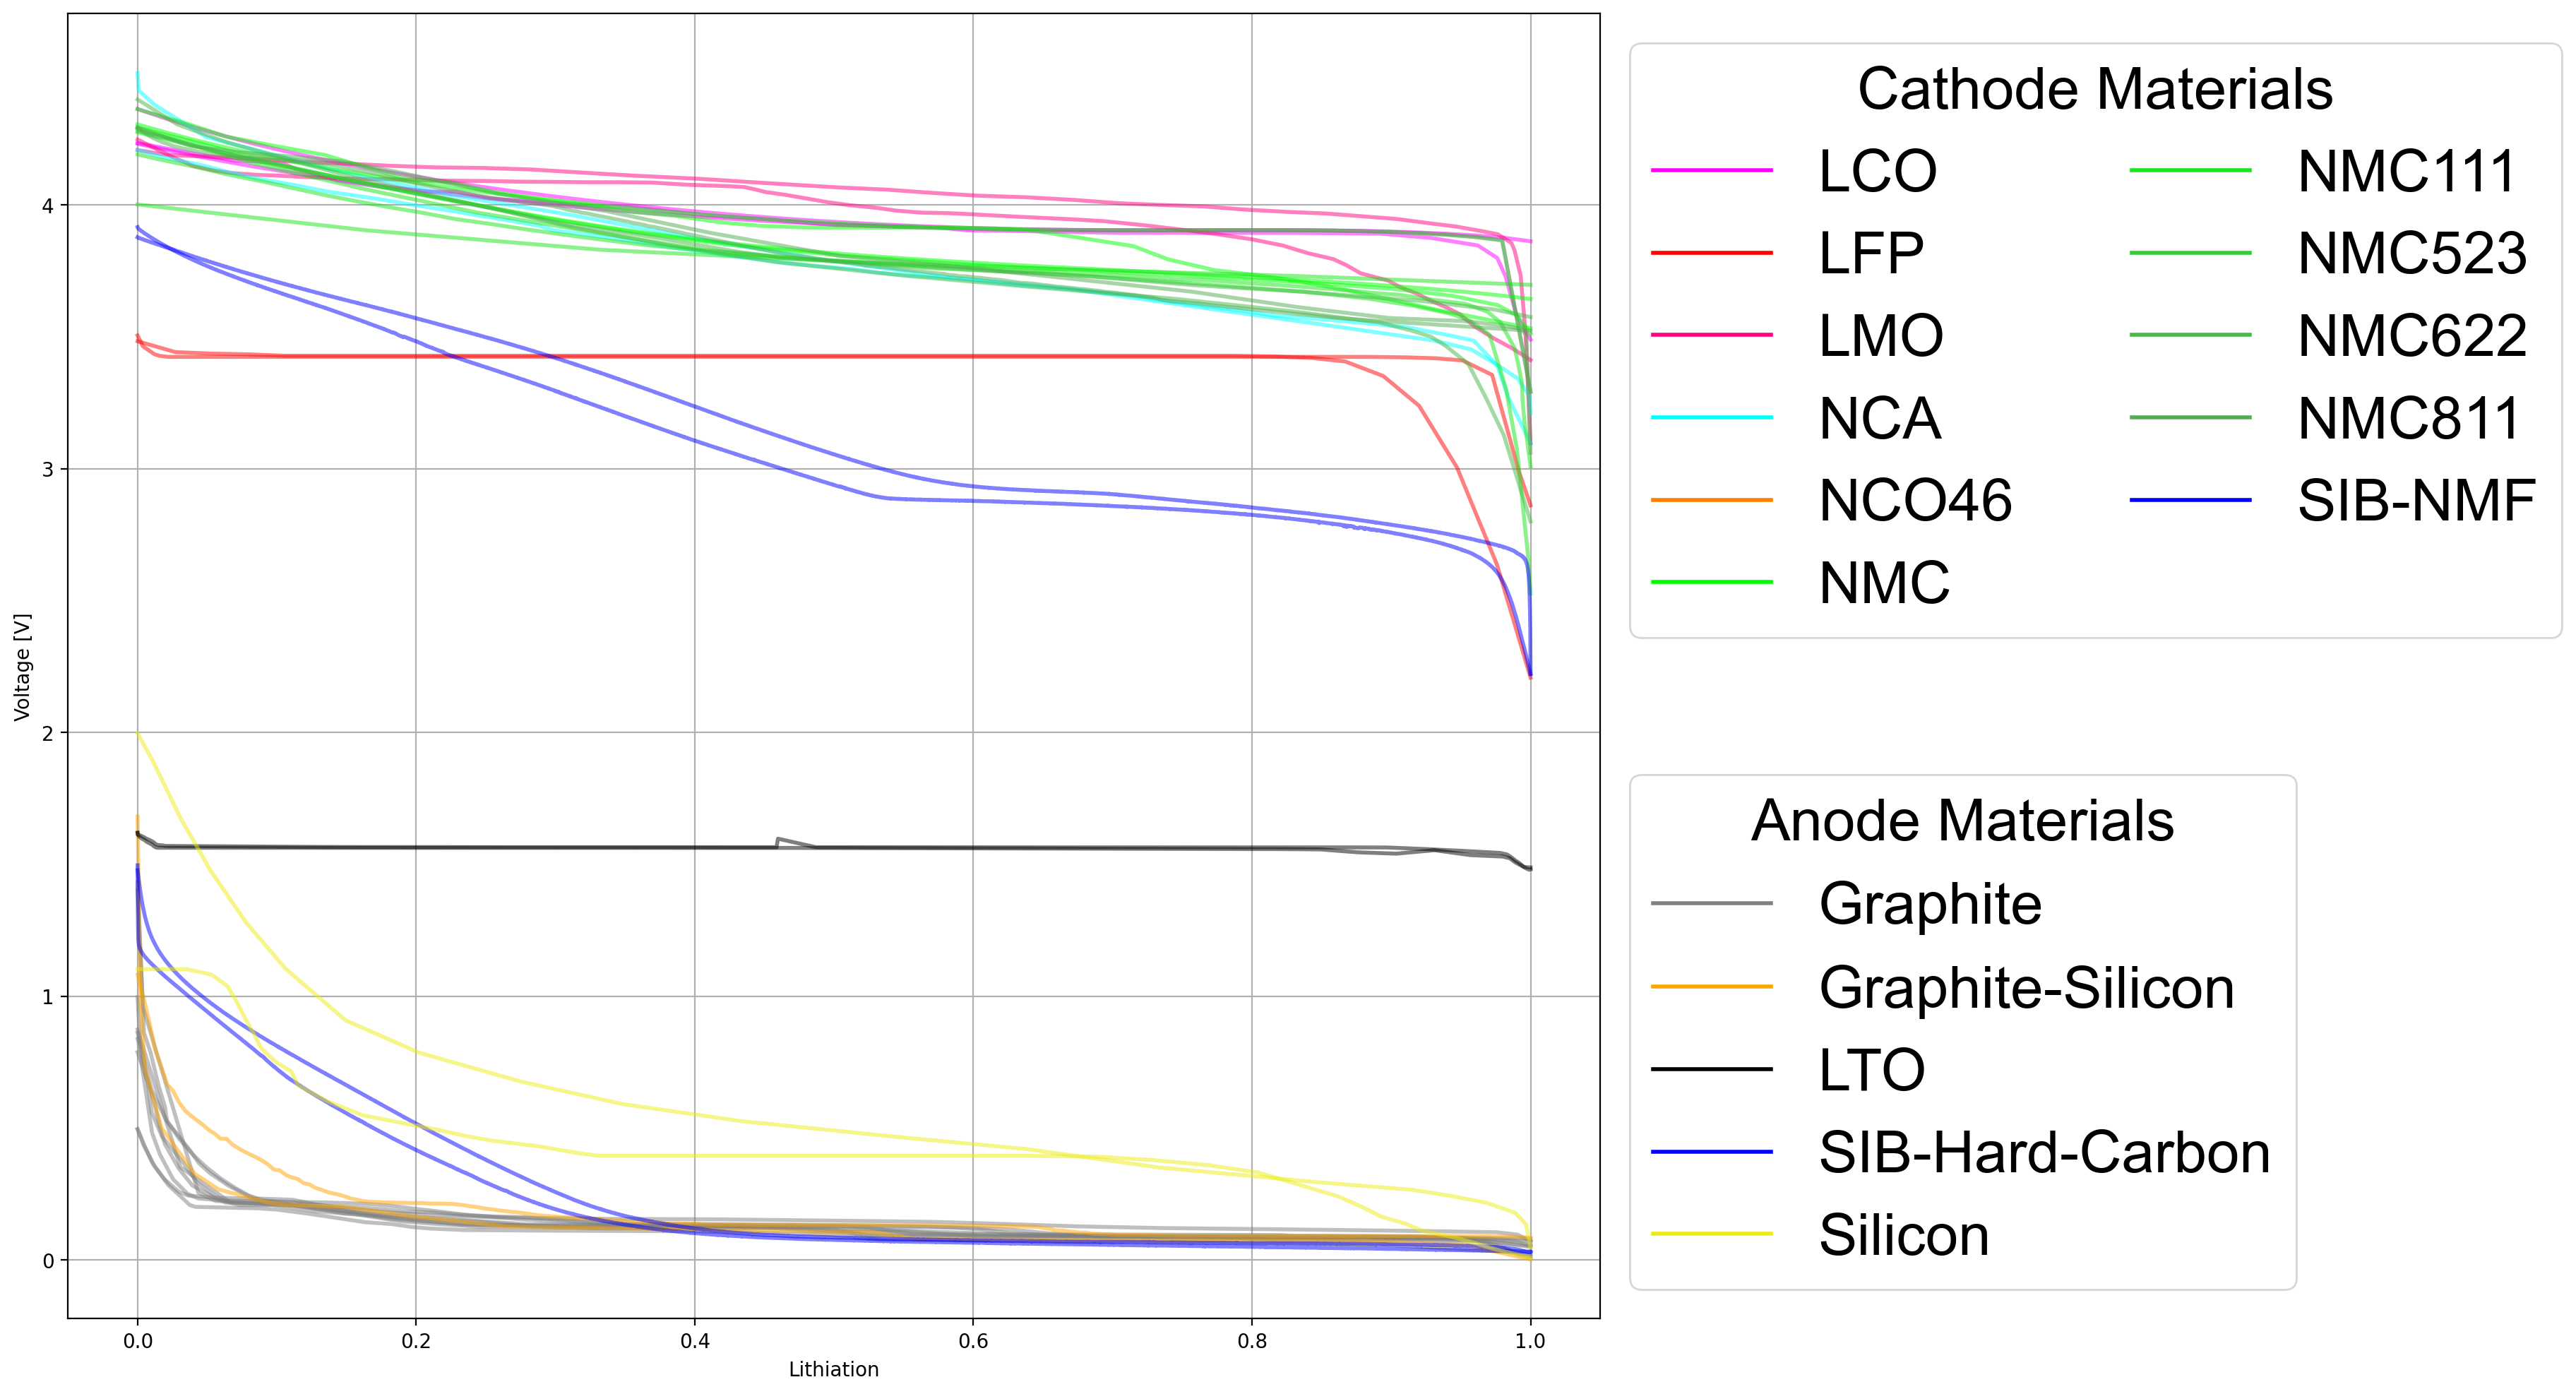

In [7]:
fig, ax = plt.subplots(figsize=(14,12), dpi=200)

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

Color_dict = {
    'LCO' : (1, 0, 1),
    'LFP' : (255/255, 0, 0),
    'LMO' : (1, 0, 0.5),
    'NCA' : (0, 1, 1),
    'NCO46': (1, 0.5, 0),
    'NMC' : [0/255,255/255,0/255],
    'NMC111' : [25/255,230/255,25/255],
    'NMC523' : [51/255,204/255,51/255],
    'NMC622' : [70/255,185/255,70/255],
    'NMC811' : [83/255,172/255,83/255],
    'LTO' : 'black',
    'Graphite':'grey',
    'Graphite-Silicon': 'orange',
    'Silicon' : [236/255, 236/255, 19/255],
    'SIB-NMF':'blue',
    'SIB-Hard-Carbon':'blue'

}


# change Linestyle
alpha = 0.5
lw =2

for idx, halfcell_anode in enumerate(halfcell_anodes):
    x = halfcell_anode.get_data()['Lithiation']
    y = halfcell_anode.get_data()['Voltage (V)']
    if (min(y)<=4):
        ax.plot(x, y, label=halfcell_anode.get_composition(), color = Color_dict[negative_materials[idx]],alpha= alpha, lw = lw)


for idx, halfcell_cathode in enumerate(halfcell_cathodes):
    x = halfcell_cathode.get_data()['Lithiation']
    y = halfcell_cathode.get_data()['Voltage (V)']
    
    if (max(y)<=4.5) and (max(y)>min(y)):
        ax.plot(x[::-1], y, label=halfcell_cathode.get_composition(),alpha= alpha,color = Color_dict[postive_materials[idx]], lw=lw)

custom_legend_cathodes = []
for material in np.unique(np.array(postive_materials)):
    custom_legend_cathodes.append(Line2D([0], [0], color=Color_dict[material], lw=lw, label=material))



custom_legend_anode = []
for material in np.unique(np.array(negative_materials)):
    custom_legend_anode.append(Line2D([0], [0], color=Color_dict[material], lw=lw, label=material))


legend_andoes = ax.legend(handles=custom_legend_anode, title="Anode Materials", loc="lower left", bbox_to_anchor=(1, 0), ncol = 1)
legend_cathodes = ax.legend(handles=custom_legend_cathodes, title="Cathode Materials", loc="upper left", bbox_to_anchor=(1, 1), ncol = 2)



ax.add_artist(legend_andoes)


# ax.legend()
ax.grid()
ax.set_ylabel('Voltage [V]')
ax.set_xlabel('Lithiation')

In [8]:
halfcell_anodes[0].get_data().head()

,index,Lithiation,Voltage (V)
0,0,0.000000,0.87429
1,1,0.030668,0.35314
2,2,0.066436,0.21943
3,3,0.097104,0.20914
4,4,0.127772,0.18514


In [9]:
Test = [halfcell for halfcell in halfcell_anodes if halfcell.get_composition()[0:3]=='SIB']
Test[0].get_data().sort_values('Lithiation').reset_index()



,level_0,index,Lithiation,Voltage (V)
0,0,10000,0.0000,1.49685
1,1,9999,0.0001,1.41053
2,2,9998,0.0002,1.33618
3,3,9997,0.0003,1.27413
4,4,9996,0.0004,1.23625
...,...,...,...,...
9996,9996,6,0.9996,0.03235
9997,9997,19,0.9997,0.03235
9998,9998,4,0.9998,0.03235
9999,9999,2,0.9999,0.03235


In [10]:
halfcell_anodes[0].get_data().head()

,index,Lithiation,Voltage (V)
0,0,0.000000,0.87429
1,1,0.030668,0.35314
2,2,0.066436,0.21943
3,3,0.097104,0.20914
4,4,0.127772,0.18514


In [11]:
# cell_cap=2000 #mAh
# calc_max_cpu()


# PATH = r'..\iOCVData\Poster'
# EXT = '*.txt'


# results = []
# for path, subdir, files in os.walk(PATH):
#     for filepath in glob(os.path.join(path, EXT)):
#         Data =pd.read_csv(filepath, sep=" ")
#         name = filepath[-13:-10]
#         results.append(get_material(cell_cap,[Data], [name], "COBYLA",False))

        




# # best_result = get_material(cell_cap,[df_nmc], ["LFP-HighV"], "COBYLA",False)

RMSE: 8.7989 mV
Match: Anode:Graphite, Kumaresan2008 Cathode:LFP, Prada2012
Solution: ['0.0004', '1.0', '0.3999', '1.0']
Anode alpha_an,beta_an = [ 1.00041154e+00 -4.11542191e-04]
Cathode alpha_cat,beta_cat = [ 1.66641976 -0.66641976]
an_cap=2000.823084382336 mAh, cat_cap=3332.839517678322 mAh
LLI:  -0.0004


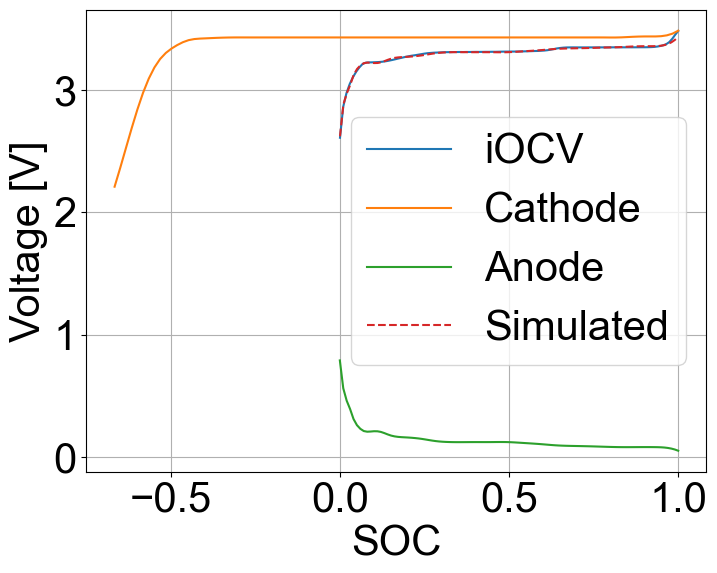

In [12]:
cell_cap=2000 #mAh
calc_max_cpu()
df_nmc= pd.read_csv(r"../iOCVData\TC23LFP01_CU_25deg.txt", sep=" ")
best_result_LFP = get_material(cell_cap,[df_nmc], ["LFP-HighV"], "COBYLA",False)

RMSE: 11.2869 mV
Match: Anode:Graphite, Liebig2019 Cathode:NMC811, Chen2020
Solution: ['0.0086', '0.7649', '0.3021', '0.9467']
Anode alpha_an,beta_an = [ 1.32220427 -0.0113662 ]
Cathode alpha_cat,beta_cat = [ 1.55140394 -0.46867471]
an_cap=2644.4085300679817 mAh, cat_cap=3102.807870412997 mAh
LLI:  -0.0114


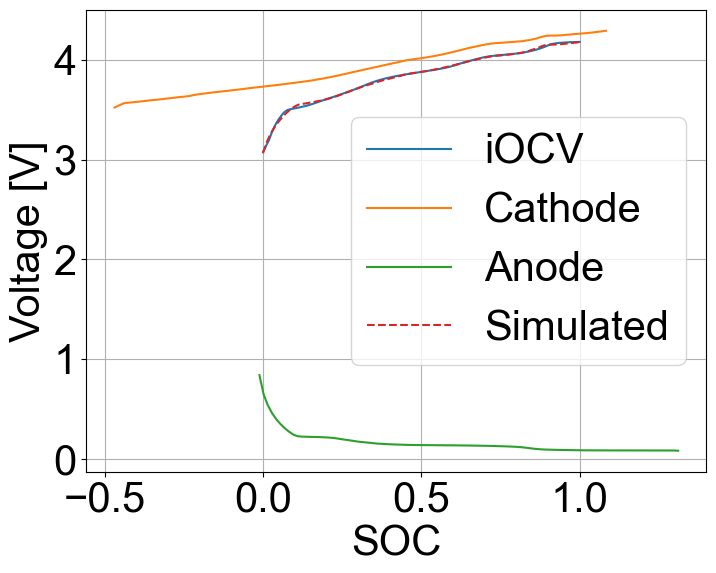

In [13]:
cell_cap=2000 #mAh
calc_max_cpu()
df_nmc= pd.read_csv(r"../iOCVData\TC23NMC01_CU_25deg.txt", sep=" ")
best_result_NMC = get_material(cell_cap,[df_nmc], ["LFP-HighV"], "COBYLA",False)

RMSE: 14.827 mV
Match: Anode:LTO, Fu2017_1 Cathode:NCO46, Ecker2015
Solution: ['-0.0', '0.9413', '0.3001', '0.7811']
Anode alpha_an,beta_an = [1.06230561e+00 1.00223228e-21]
Cathode alpha_cat,beta_cat = [ 2.07880434 -0.62379309]
an_cap=2124.6112167560427 mAh, cat_cap=4157.608680833864 mAh
LLI:  0.0


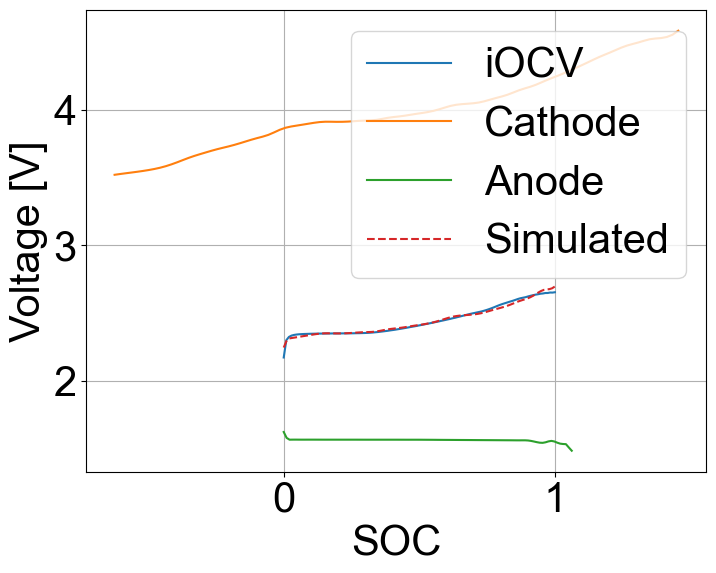

In [14]:
cell_cap=2000 #mAh
calc_max_cpu()
df_nmc= pd.read_csv(r"../iOCVData\TC23LTO01_CU_25deg.txt", sep=" ")
best_result_LTO = get_material(cell_cap,[df_nmc], ["LFP-HighV"], "COBYLA",False)

RMSE: 99.7661 mV
Match: Anode:Silicon, Li2012_Si Cathode:NMC811, Sturm2019
Solution: ['0.0378', '0.8601', '0.0298', '1.0']
Anode alpha_an,beta_an = [ 1.21615787 -0.04602422]
Cathode alpha_cat,beta_cat = [ 1.03067228 -0.03067228]
an_cap=2432.3157439922115 mAh, cat_cap=2061.3445619156823 mAh
LLI:  -0.046


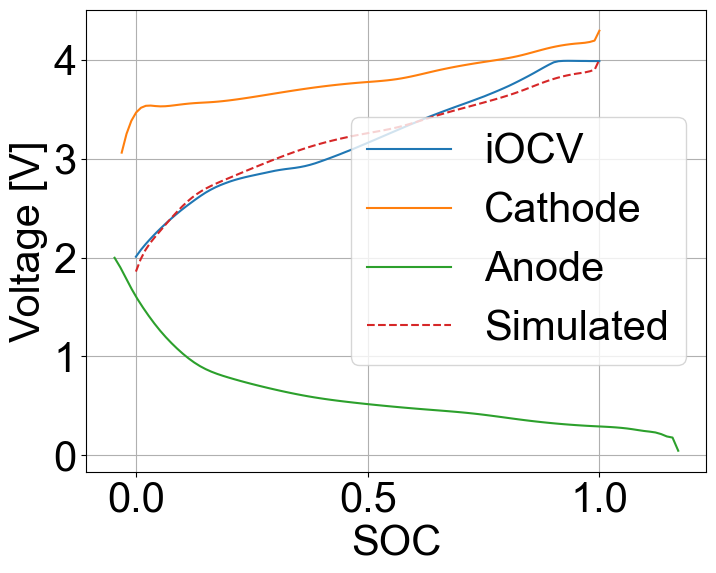

In [15]:
cell_cap=2000 #mAh
calc_max_cpu()
df_nmc= pd.read_csv(r"../iOCVData\TC23SIB01_CU_25deg.txt", sep=" ")
best_result_SIB = get_material(cell_cap,[df_nmc], ["LFP-HighV"], "COBYLA",False)

Graphite
NMC811
Graphite
LFP
Silicon
NMC811
LTO
NCO46


(-1.1, 110.0)

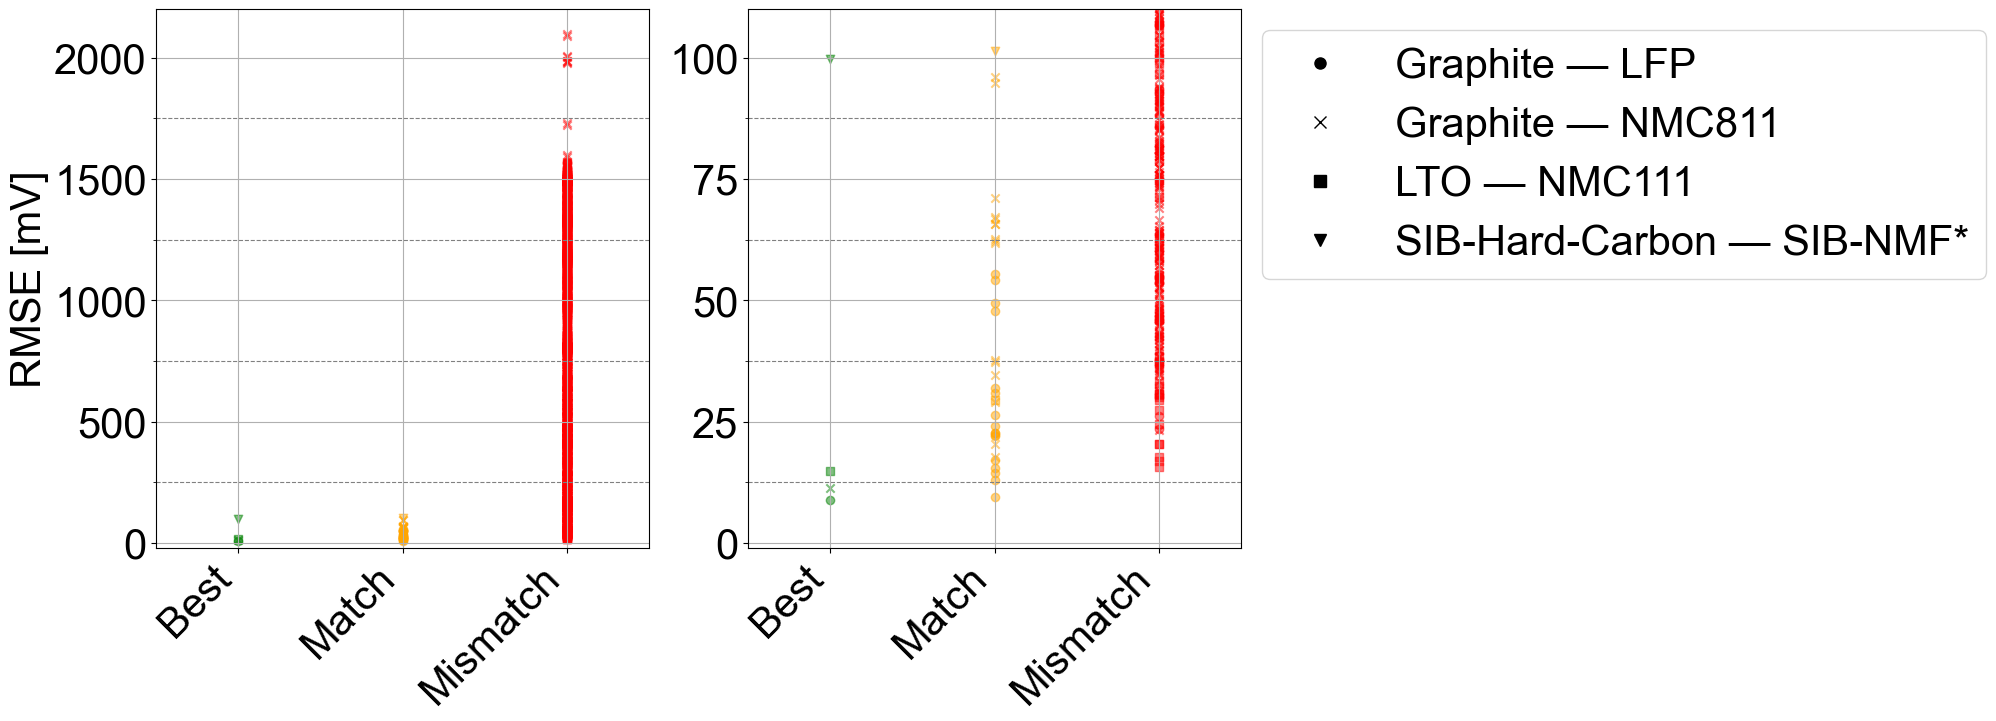

In [20]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
from matplotlib.ticker import MultipleLocator

NMC_Anode = best_result_NMC[best_result_NMC['RMSE']==min(best_result_NMC['RMSE'])].iloc[0]['Halfcell Anode'].split(',')[0]
NMC_Cathode = best_result_NMC[best_result_NMC['RMSE']==min(best_result_NMC['RMSE'])].iloc[0]['Halfcell Cathode'].split(',')[0]
print(NMC_Anode)
print(NMC_Cathode)

for idx, line in best_result_NMC.iterrows():
    if (line['Halfcell Anode'].split(',')[0]==NMC_Anode) and (line['Halfcell Cathode'].split(',')[0]== NMC_Cathode):
        if line['RMSE']<=200 and (line['RMSE']>min(best_result_NMC['RMSE'])):
            ax[0].scatter(2,line['RMSE'], color = 'orange', marker = 'x', alpha= 0.5)
            ax[1].scatter(2,line['RMSE'], color = 'orange', marker = 'x', alpha= 0.5)
    else:
        ax[0].scatter(3,line['RMSE'], color = 'red', marker='x', alpha= 0.5)
        ax[1].scatter(3,line['RMSE'], color = 'red', marker = 'x', alpha= 0.5)

LFP_Anode = best_result_LFP[best_result_LFP['RMSE']==min(best_result_LFP['RMSE'])].iloc[0]['Halfcell Anode'].split(',')[0]
LFP_Cathode = best_result_LFP[best_result_LFP['RMSE']==min(best_result_LFP['RMSE'])].iloc[0]['Halfcell Cathode'].split(',')[0]
print(LFP_Anode)
print(LFP_Cathode)
for idx, line in best_result_LFP.iterrows():
    if (line['Halfcell Anode'].split(',')[0]==LFP_Anode) and (line['Halfcell Cathode'].split(',')[0]== LFP_Cathode):
        if line['RMSE']<=200 and (line['RMSE']>min(best_result_LFP['RMSE'])):
            ax[0].scatter(2,line['RMSE'], color = 'orange', alpha= 0.5)
            ax[1].scatter(2,line['RMSE'], color = 'orange', alpha= 0.5)
    else:
        ax[0].scatter(3,line['RMSE'], color = 'red', alpha= 0.5)
        ax[1].scatter(3,line['RMSE'], color = 'red', alpha= 0.5)

SIB_Anode = best_result_SIB[best_result_SIB['RMSE']==min(best_result_SIB['RMSE'])].iloc[0]['Halfcell Anode'].split(',')[0]
SIB_Cathode = best_result_SIB[best_result_SIB['RMSE']==min(best_result_SIB['RMSE'])].iloc[0]['Halfcell Cathode'].split(',')[0]
print(SIB_Anode)
print(SIB_Cathode)
for idx, line in best_result_SIB.iterrows():
    if (line['Halfcell Anode'].split(',')[0]==SIB_Anode) and (line['Halfcell Cathode'].split(',')[0]== SIB_Cathode):
        if line['RMSE']<=200 and (line['RMSE']>min(best_result_SIB['RMSE'])):
            ax[0].scatter(2,line['RMSE'], color = 'orange',marker='v', alpha= 0.5)
            ax[1].scatter(2,line['RMSE'], color = 'orange', marker='v', alpha= 0.5)
    else:
        ax[0].scatter(3,line['RMSE'], color = 'red',marker='v', alpha= 0.5)
        ax[1].scatter(3,line['RMSE'], color = 'red',marker='v', alpha= 0.5)


LTO_Anode = best_result_LTO[best_result_LTO['RMSE']==min(best_result_LTO['RMSE'])].iloc[0]['Halfcell Anode'].split(',')[0]
LTO_Cathode = best_result_LTO[best_result_LTO['RMSE']==min(best_result_LTO['RMSE'])].iloc[0]['Halfcell Cathode'].split(',')[0]
print(LTO_Anode)
print(LTO_Cathode)
for idx, line in best_result_LTO.iterrows():
    if (line['Halfcell Anode'].split(',')[0]==LTO_Anode) and (line['Halfcell Cathode'].split(',')[0]== LTO_Cathode):
        if line['RMSE']<=200 and (line['RMSE']>min(best_result_LTO['RMSE'])):
            ax[0].scatter(2,line['RMSE'], color = 'orange', marker='s',alpha= 0.5)
            ax[1].scatter(2,line['RMSE'], color = 'orange', marker='s',alpha= 0.5)
    else:
        ax[0].scatter(3,line['RMSE'], color = 'red',marker='s', alpha= 0.5)
        ax[1].scatter(3,line['RMSE'], color = 'red',marker='s', alpha= 0.5)



ax[0].scatter(1,min(best_result_NMC['RMSE']), color = 'green', marker = 'x', alpha= 0.5)
ax[0].scatter(1,min(best_result_LFP['RMSE']), color = 'green', marker = 'o', alpha= 0.5)
ax[1].scatter(1,min(best_result_NMC['RMSE']), color = 'green', marker = 'x', alpha= 0.5)
ax[1].scatter(1,min(best_result_LFP['RMSE']), color = 'green', marker = 'o', alpha= 0.5)

ax[0].scatter(1,min(best_result_LTO['RMSE']), color = 'green', marker = 's', alpha= 0.5)
ax[0].scatter(1,min(best_result_SIB['RMSE']), color = 'green', marker = 'v', alpha= 0.5)
ax[1].scatter(1,min(best_result_LTO['RMSE']), color = 'green', marker = 's', alpha= 0.5)
ax[1].scatter(1,min(best_result_SIB['RMSE']), color = 'green', marker = 'v', alpha= 0.5)

# ax.scatter(best_result_NMC.index,best_result_NMC['RMSE'], color = Color_dict['NMC'])
# ax.scatter(best_result_LFP.index,best_result_LFP['RMSE'], color = Color_dict['LFP'])
# ax.set_ylim(0,100)
ax[0].set_ylabel('RMSE [mV]')


ax[0].set_xticks([1,2,3],['Best', 'Match', 'Mismatch'],rotation=45,ha='right')
ax[1].set_xticks([1,2,3],['Best', 'Match', 'Mismatch'],rotation=45,ha='right')
ax[0].grid(visible=True,which='major')
ax[1].grid(visible=True,which='major')
ax[0].grid(visible=True,which='minor',linestyle='--',color='grey')
ax[1].grid(visible=True,which='minor',linestyle='--',color='grey')
ax[0].yaxis.set_minor_locator(MultipleLocator(250))
ax[1].yaxis.set_minor_locator(MultipleLocator(12.5))
ax[0].set_yticks([0,500,1000,1500,2000])
ax[1].set_yticks([0,25,50,75,100])

custom_legend = [
    Line2D([0], [0],color="w", marker = 'o', markerfacecolor="black",markeredgecolor="black", label="Graphite — LFP",markersize=8),
    Line2D([0], [0],color="w", marker="x", markerfacecolor="black",markeredgecolor="black", label="Graphite — NMC811",markersize=8),
    Line2D([0], [0],color="w", marker="s", markerfacecolor="black",markeredgecolor="black", label="LTO — NMC111",markersize=8),
    Line2D([0], [0],color="w", marker="v", markerfacecolor="black",markeredgecolor="black", label="SIB-Hard-Carbon — SIB-NMF*",markersize=8)
]

ax[1].legend(handles=custom_legend, loc="upper left", bbox_to_anchor=(1, 1))
ax[0].set_xlim(0.5,3.5)
ax[1].set_xlim(0.5,3.5)
ax[0].set_ylim(-22,2200)
ax[1].set_ylim(-1.1,110)





In [ ]:
(NMC_Anode['RMSE'])

TypeError: string indices must be integers, not 'str'